# **Aprendizaje Automático para Machine Learning**

##Generación de texto##

###Andrea Azábal Lamoso###

27 de julio de 2021

---

# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos se compone de obras de H.P. Lovecraft, aunque se puede utilizar cualquier otro.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [ ]:
!pip install progressbar2

In [ ]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html

import nltk
from nltk import word_tokenize
nltk.download('punkt')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
use_moses_detokenizer=False


## Definición de parámetros del corpus y su preprocesado

In [ ]:
corpus_url = "https://archive.org/stream/TheCollectedWorksOfH.p.Lovecraft/The-Collected-Works-of-HP-Lovecraft_djvu.txt"
corpus_path = "lovecraft.txt"
preprocessed_corpus_path = "lovecraft_preprocessed.p"
most_common_words_number = 10000


## Transformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [ ]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [ ]:
def download_corpus_if_necessary():

    if not os.path.exists(corpus_path):
        print("Descargamos el corpus...")

        # Descargamos el contenido
        corpus_string = urllib.request.urlopen(corpus_url).read().decode('utf-8')

        # Eliminamos etiquetas HTML
        index = corpus_string.index("<pre>")
        corpus_string = corpus_string[index + 5:]
        index = corpus_string.find("</pre>")
        corpus_string = corpus_string[:index ]
        corpus_string = html.unescape(corpus_string)

        # Grabamos en fichero
        corpus_file = open(corpus_path, "w")
        corpus_file.write(corpus_string)
        corpus_file.close()

        print("El corpus se ha grabado en", corpus_path)
    else:
        print("El corpus ya estaba grabado")

download_corpus_if_necessary()

Descargamos el corpus...
El corpus se ha grabado en lovecraft.txt


In [ ]:
# SI NO FUNCIONA, EJECUTAR:
#!rm lovecraft.txt
#!wget https://github.com/albertojulian/master-ub/raw/main/lovecraft.txt
#!ls -al lovecraft.txt

## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [ ]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path):
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

Preprocesamos el corpus...
Extraemos las palabras (tokens)...
Número de tokens: 703845
Generamos el vocabulario...
Longitud del vocabulario antes del corte: 35697
Longitud del vocabulario después del corte: 10000
Codificamos a índices...
Número de índices: 662558
Grabamos fichero de preprocesado del corpus...


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [ ]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


## Definición de la red LSTM y entrenamiento




En este apartado se definirá el algoritmo de la red neuronal para posteriormente entrenarla y evaluar su precisión (solo se define y entrena si no se ha hecho antes, o si se fuerza con el parámetro `train_anyway`).

Así, la primera capa de la red consistirá en una capa de `Embedding()`, la cual convierte cada palabra (referenciada por índices) en un vector de dimensión `hidden_size=1000`, es decir, se han seleccionado las 10.000 palabras más repetidas en el corpus y se les ha asignado un vector de dimensión 1.000 a cada una de ellas. También debe indicarse la longitud de los textos del *dataset* de entrenamiento, donde se ha seleccionado `sequence_length = 30` palabras.

A continuación, se añade la capa `LSTM` de dimensión 1.000, esto es, su dimensión es la misma que la salida de la capa anterior.

Finalmente, se añade una capa `Dense()` de dimensión igual al número total de palabras, 10.000. De esta forma, a cada palabra del *dataset* se le asigna una probabilidad aplicando la función `Softmax`.

Por último, se graba el modelo.

N/A% (0 of 50000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--


Generamos el dataset...


100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 10000)             10010000  
_________________________________________________________________
activation (Activation)      (None, 10000)             0         
Total params: 28,014,000
Trainable params: 28,014,000
Non-trainable params: 0
_________________________________________________________________
Entrenamos el modelo...
Epoch 1/10
313/313 [==============================] - 59s 163ms/step - loss: 6.6497 - accuracy: 0.0899 - val_loss: 6.1972 - val_accuracy: 0.1227
Epoch 2/10
313/313 [==============================] 

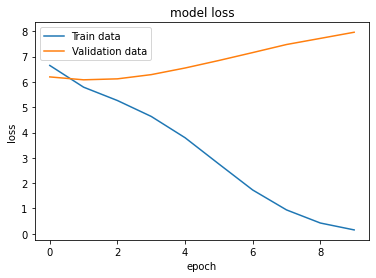

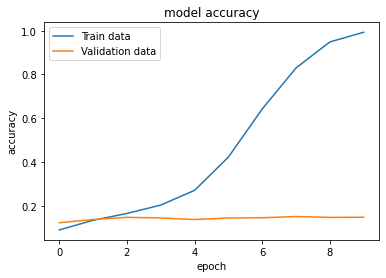

In [ ]:
# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de iteraciones a entrenar
batch_size = 128 # tamaño de lote
hidden_size = 1000 # número de nodos en la red LSTM
model_path = "lovecraft_model.h5"

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:

        # Carga de las palabras del corpus y sus índices
        indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

        # Generación del dataset
        print("\nGeneramos el dataset...")
        data_input, data_output = get_dataset(indices)
        data_output = to_categorical(data_output, num_classes=len(vocabulary))

        # Creación del modelo
        print("Creamos el modelo...")
        # COMPLETAR CODIGO (debes seguir las indicaciones de la actividad para generar la red LSTM) 
        model = models.Sequential()
        model.add(layers.Embedding(len(vocabulary), hidden_size, input_length=sequence_length))
        model.add(layers.LSTM(hidden_size))
        model.add(layers.Dense(len(vocabulary)))
        model.add(layers.Activation('softmax'))
        model.summary()

        # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

        # Entrenamiento del modelo
        print("Entrenamos el modelo...")
        history = model.fit(data_input, data_output, epochs=epochs, 
                            batch_size=batch_size, validation_split=0.2)
        
        # Grabación del modelo
        print("...y grabamos el modelo")
        model.save(model_path)

        plot_history(history)
        

def plot_history(history):

    print(history.history.keys())

    # Gráfica de función de pérdida
    plt.plot(history.history['loss'], label='Train data')
    plt.plot(history.history['val_loss'], label='Validation data')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig("history_loss.png")
    # plt.clf()
    plt.show()
    plt.close()
    
    # Gráfica de accuracy.
    plt.plot(history.history['accuracy'], label='Train data')
    plt.plot(history.history['val_accuracy'], label='Validation data')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig("history_accuracy.png")
    # plt.clf()

    plt.show()
    plt.close()
        
train_neural_network()

Al entrenar el modelo, vemos cómo a medida que avanzan las iteraciones o *epochs*, disminuye la función de pérdida y aumenta la precisión sobre el *dataset* de entrenamiento, de manera que al transcurso de 10 iteraciones se tiene una precisión muy próxima al 100%.

Para el subconjunto de evaluación, sin embargo, no se aprecia lo mismo, sino que la función de pérdida alcanza un mínimo para después ir aumentando con el avance en las iteraciones. La precisión sobre este subconjunto se mantiene constante, en torno al 15%, lo cual indica que el modelo no es capaz de predecir la siguiente palabra en la mayoría de casos. Se tiene, por tanto, un sobreajuste al *dataset* de entrenamiento (*overfitting*). 

El hecho de que la red no sea capaz de predecir la siguiente palabra en nuevos textos no implica necesariamente que el generador de texto no vaya  a ser capaz de elaborar textos coherentes. Sin embargo, debido a esta escasa capacidad de predicción sobre nuevos conjuntos de datos, cabe esperar que las palabras generadas no "encajen" con el texto semilla. Para comprobarlo, vamos a proceder a evaluar si el algoritmo entrenado es capaz de generar textos coherentes y con sentido.

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice a partir de una predicción y un parámetro de temperatura.

Con el objetivo de generar 15 textos de 50 palabras cada uno, en primer lugar cargamos de nuevo el corpus y el modelo generado.

A continuación, para cada texto seleccionamos un valor aleatorio y lo almacenamos en el parámetro `temperature`. Este parámetro añade variabilidad en la predicción, de manera que con una temperatura baja  se modificará la distribución para maximizar todavía más las probabilidades más altas y minimizar las más bajas. En cambio, una temperatura alta igualará más la distribución de probabilidad, dando opción a palabras menos probables a ser las seleccionadas. Es decir, las temperaturas bajas son más conservadoras, mientras que para las temperaturas altas se tienen predicciones más "arriesgadas". Además, se tiene el caso particular $T = 0$, para el cual simplemente se selecciona la predicción más probable, lo que equivale a una ausencia de aleatoriedad.

Asimismo, se selecciona una secuencia aleatoria de índices (palabras) del corpus a partir de la cual queremos generar el texto. Pasamos esta secuencia al modelo (`model.predict()`) y extraemos el índice de la predicción, introduciendo una cierta aleatoriedad mediante `temperature` con el objetivo de no predecir siempre la misma palabra/índice.

Se realiza la predicción del modelo hasta llegar al número máximo de palabras: 50. En cada predicción, se va modificando el *input* que se le introduce al modelo, añadiendo una nueva palabra generada y deshaciéndonos de una de las palabras originales en la secuencia `input_sequence`, de manera que el tamaño del *input* se mantiene siempre constante. Además, vamos almacenando los índices de cada predicción y, una vez se tienen todos, se utiliza la función `decode_indices()` para "decodificar" cada uno y recuperar la palabra original del corpus. 

El resultado que se obtiene es el siguiente:

In [ ]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for i in range(n_generated_texts):
        print("# texto:", i+1)
        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Mostramos la secuancia aleatoria y el texto a continuación
        text_input = decode_indices(input_sequence, vocabulary)
        print("- Texto semilla:")
        print(text_input)
        original_sequence = indices[random_index:random_index + sequence_length + 50]
        text_original = decode_indices(original_sequence, vocabulary)
        print("- Texto semilla y continuación:")
        print(text_original)

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0))
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            input_sequence.append(predicted_index)
            

        # Convertimos la secuencia de índices generada en una frase
        print("- Texto generado:")
        text = decode_indices(generated_sequence, vocabulary)
        print(text)
        print("")

        
def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)

Generamos 15 textos...
# texto: 1
Temperatura: 0.6488112213561746
- Texto semilla:
hysteria . He insisted that this shadowy bungalow possessed no library possessed no library or laboratory beyond the visible ones , and waxed in explaining the absence from the house
- Texto semilla y continuación:
hysteria . He insisted that this shadowy bungalow possessed no library possessed no library or laboratory beyond the visible ones , and waxed in explaining the absence from the house of such odours as now all his clothing . gossip he attributed to nothing more than the cheap of baffled curiousity . Of the whereabouts of Dr. Allen he said he did not feel at liberty to speak definitely , but assured his that the bearded and spectacled man would
- Texto generado:
was a signs of sweet , April columns with a quiet with sight of his fevered steep peaks , whose gods may have been during the nameless city ; where which had the many orbit of face had held down in certain vast the seaport of the illusio

En el *output* se pueden ver tres textos:

- Texto semilla: secuencia aleatoria que se ha utilizado para realizar la predicción.
- Texto semilla y continuación: la secuencia aleatoria original y el texto que le continúa en el corpus.
- Texto generado: texto resultante de la predicción.



Como se puede comprobar, las sentencias generadas no tienen coherencia o sentido independientemente de la temperatura seleccionada. Si nos fijamos, en muchos casos la primera palabra del texto generado coincide con la palabra del corpus que prosigue al *input*, por ejemplo palabras nexo como "*the*" en el texto 15 u "*of*" en el texto 5. Sin embargo, el algoritmo enseguida "diverge" y, por tanto, las predicciones de las palabras siguientes no concuerdan con el corpus original.


Aun así, sí que se observa que las palabras generadas siguen ciertas reglas gramaticales como la presencia de verbos después del sujeto ("*I could not have done*",  "*the old man was*", etc.). Los signos de puntuación no se emplean correctamente, aunque parece que todas las oraciones tienen longitudes razonables hasta la aparición de un punto o una coma. El vocabulario que utiliza es bastante amplio y se hace evidente que la red ha aprendido de obras literarias relativamente antiguas, cuyo estilo de escritura es formal e incluso arcaico. 

Por otra parte, comprobamos que se repiten algunas de las palabras en cada texto generado independientemente del valor del parámetro `temperature`. Por ejemplo, en el texto 4 ($T=0,87$), se repite el verbo ("*be be*"), mientras que en el texto 13 ($T=0.35$) se repite un adverbio ("*only only*"). En resumen, no parece que el hecho de haber añadido el parámetro de temperatura esté afectando mucho a los resultados, pues no observamos grandes diferencias entre una temperatura alta (suaviza la distribución de probabilidad y proporciona más diversidad) y una temperatura baja (proporciona una distribución de probabilidad más conservadora y  menos libertad en la generación).



#Conclusiones

A lo largo de esta tarea, se ha entrenado una red neuronal recurrente  (RNN) con el fin de generar textos. A diferencia de una red neuronal simple, una RNN es capaz de recordar *inputs* de capas anteriores de la red. Es decir, el *output* de las capas no están únicamente influenciados por los pesos de los *output* de las capas previas, sino que también tienen en cuenta el "contexto" derivado de *inputs* y *outputs* previos.

Este tipo de redes son muy útiles a la hora de generar textos, pues pueden memorizar palabras previas de una oración con el fin de aprender qué palabra es más probable que aparezca a continuación (dado un *random seed*). 

En nuestro caso, observamos cómo tras tan solo 10 iteraciones en el entrenamiento, la red es capaz de predecir casi al 100% la siguiente palabra en el subconjunto de entrenamiento, mientras que este porcentaje se reduce a apenas un 15% sobre el *dataset* de *testing*.

A la hora de generar el texto, observamos que las sentencias no tienen sentido, si bien parecen seguir cierta estructura semántica aprendida del corpus original, así como un estilo de escritura similar al de las obras literarias de H.P. Lovecraft. El hecho de modificar el parámetro de aleatoriedad `temperature` tampoco parece tener gran repercusión en las predicciones, observándose características muy similares en los 15 textos generados.

Con el fin de mejorar la RNN, podríamos aumentar la profundidad de la red neuronal, añadiendo más capas LSTM (con más neuronas) junto con capas *Dropout* para evitar el *overfitting*. Sin embargo, hay que tener en cuenta que entrenar este tipo de modelos es costoso computacionalmente. 

